https://www.kaggle.com/competitions/tabular-playground-series-jan-2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# df = pd.read_csv('train.csv')
from sklearn.datasets import make_regression

def make_dataframe(**kwargs):
    X, y = make_regression(**kwargs)

    X = pd.DataFrame(X, columns=[f'f{i}' for i in range(15)])
    y = pd.Series(y, name='target')

    df = pd.concat([X, y], axis=1)
    
    return df

df_1 = make_dataframe(n_samples=1000, n_features=15, noise=1, random_state=42, bias=-500)
df_2 = make_dataframe(n_samples=1000, n_features=15, noise=10, random_state=24, bias=500)

df = pd.concat([df_1, df_2], axis=0)
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,0.825853,0.547527,-1.502265,0.566760,1.707549,1.439954,0.916706,0.157099,1.068642,0.725590,0.068681,1.075627,-0.543910,-1.862864,-1.081651,-338.462570
1,-1.348177,0.691619,-0.979926,-0.533090,0.690074,-0.998212,1.087710,-1.957339,-0.344064,0.273118,-0.668143,-0.002786,0.193379,0.015682,-0.374534,-595.133258
2,-0.799192,0.436560,-0.728003,0.619154,-1.072139,-2.362932,-2.921350,-0.182896,2.057495,0.903935,1.374876,-1.009731,-0.645964,-0.482744,0.020794,-657.305700
3,0.704336,-0.803111,0.394958,1.101738,-0.802272,2.721912,-0.504634,1.072930,0.491993,-0.731857,-0.853399,0.844456,0.965327,1.852040,-1.606257,-399.422952
4,1.179297,-0.142379,0.332314,-1.124642,0.622850,0.514439,-1.067620,-0.748487,-1.534114,0.120296,1.551152,0.711615,0.115675,0.067518,1.277677,-423.879889


In [3]:
df.shape

(2000, 16)

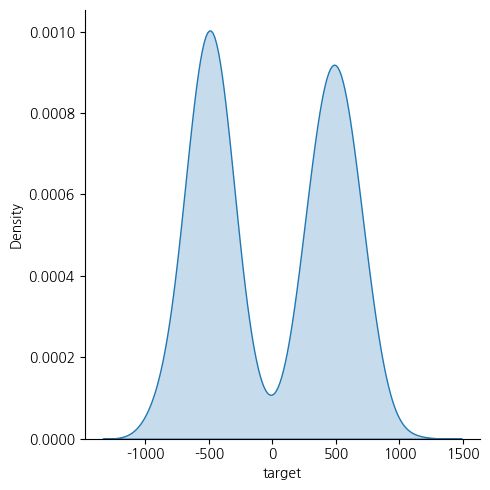

In [4]:
sns.displot(data=df, x='target', kind='kde', fill=True)
plt.show()

In [5]:
label = 'target'

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=0)

In [7]:
train.shape, test.shape

((1800, 16), (200, 16))

# 하나의 regressor

In [8]:
from xgboost import XGBRegressor

predictor0 = XGBRegressor().fit(train.drop(columns=label), train[label])

In [9]:
def evaluate(y_real, y_pred):
    if isinstance(list(y_pred)[0], (int, np.int32, np.int64)):
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        acc = accuracy_score(y_real, y_pred)
        prc = precision_score(y_real, y_pred)
        rec = recall_score(y_real, y_pred)
        f1 = f1_score(y_real, y_pred)
        
        return pd.Series([acc, prc, rec, f1], index=['Accuracy', 'Precision', 'Recall', 'F1'])
    
    else:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        from scipy.stats import pearsonr
        
        mae = mean_absolute_error(y_real, y_pred)
        rmse = np.sqrt(mean_squared_error(y_real, y_pred))
        r2 = r2_score(y_real, y_pred)
        corr, _ = pearsonr(y_real, y_pred)
        
        return pd.Series([mae, rmse, r2, corr], index=['MAE', 'RMSE', 'R2', 'PearsonR'])

In [10]:
pred0 = predictor0.predict(test.drop(columns=label))

In [11]:
evaluate(test[label], pred0)

MAE         511.005427
RMSE        568.887866
R2           -0.148041
PearsonR      0.104974
dtype: float64

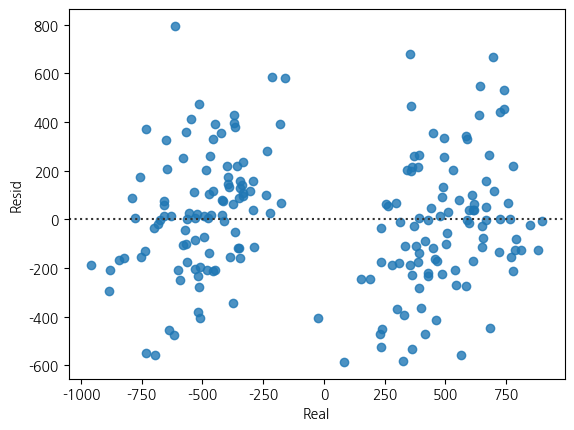

In [12]:
sns.residplot(x=test[label], y=pred0)
plt.xlabel('Real')
plt.ylabel('Resid')
plt.show()

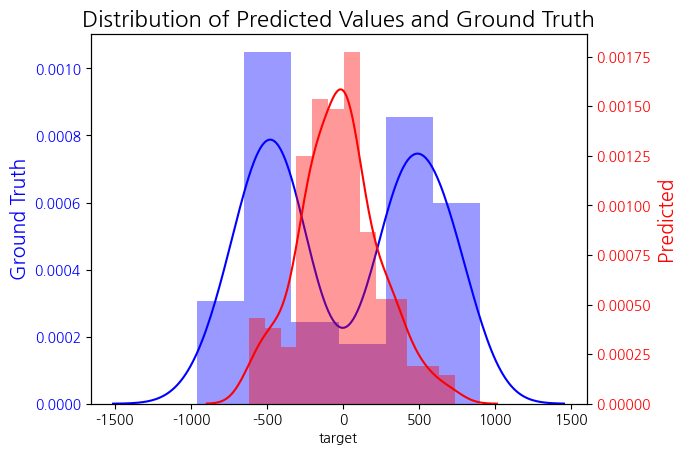

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(pred0, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

# 2개의 분류모델, 2개의 회귀모델

In [14]:
from SplittedRegressor import SplittedRegressor1
from xgboost import XGBClassifier, XGBRegressor

predictor1 = SplittedRegressor1(label, XGBClassifier(), XGBClassifier(), XGBRegressor(), XGBRegressor()).fit(train, center=0, alpha=50)

In [15]:
predictor1.evaluate(test.drop(columns=label), test[label])

,0
root_mean_squared_error,709.145664
mean_absolute_error,551.956392
r2,-0.783918
pearsonr,-0.016196


In [16]:
pred1 = predictor1.predict(test.drop(columns=label))

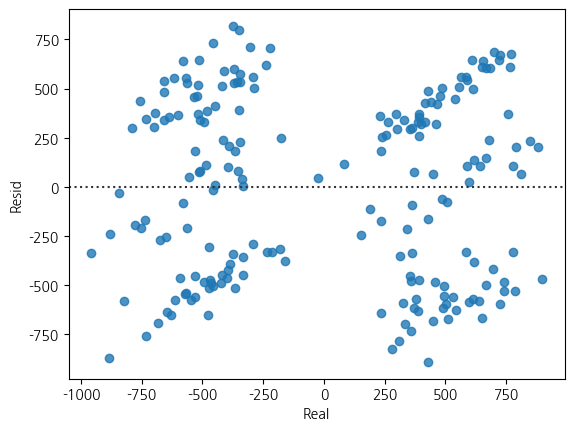

In [17]:
sns.residplot(x=test[label], y=pred1)
plt.xlabel('Real')
plt.ylabel('Resid')
plt.show()

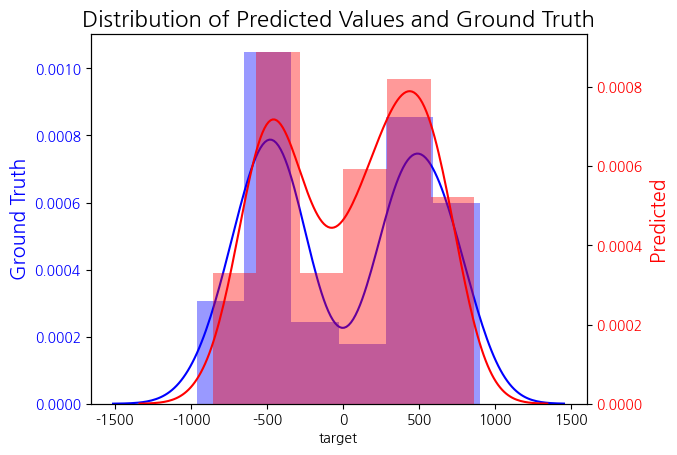

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(pred1, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

In [28]:
predictor1_a = SplittedRegressor1(label, XGBClassifier(), XGBClassifier(), XGBRegressor(), XGBRegressor()).fit(train, center=0, alpha=25)
predictor1_b = SplittedRegressor1(label, XGBClassifier(), XGBClassifier(), XGBRegressor(), XGBRegressor()).fit(train, center=0, alpha=100)

display(predictor1_a.evaluate(test.drop(columns=label), test[label]))
display(predictor1_b.evaluate(test.drop(columns=label), test[label]))

,0
root_mean_squared_error,699.417850
mean_absolute_error,536.716587
r2,-0.735311
pearsonr,0.023183


,0
root_mean_squared_error,696.475239
mean_absolute_error,547.030931
r2,-0.720740
pearsonr,-0.037825


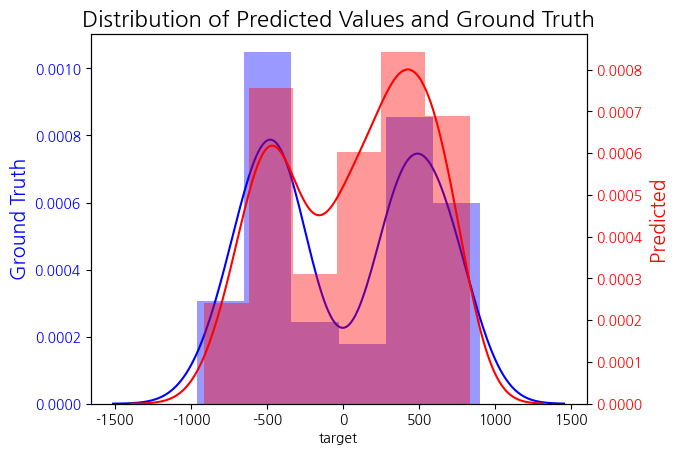

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(predictor1_a.predict(test.drop(columns=label)), ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

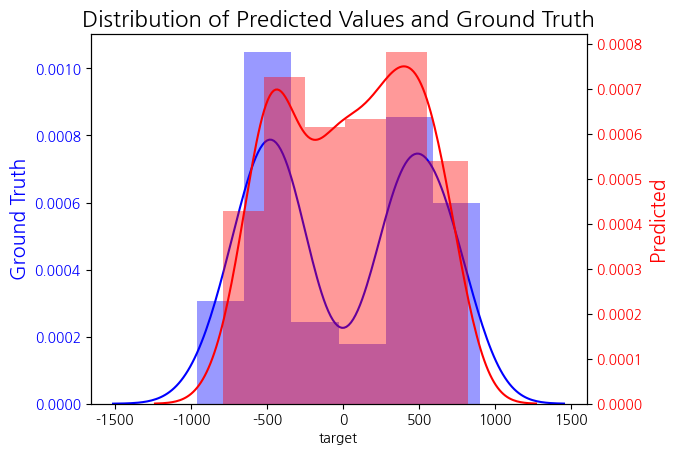

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(predictor1_b.predict(test.drop(columns=label)), ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

# 1개의 분류모델, 2개의 회귀모델

In [19]:
from SplittedRegressor import SplittedRegressor2

predictor2 = SplittedRegressor2(label, XGBClassifier(), XGBRegressor(), XGBRegressor()).fit(train, center=0)

In [20]:
predictor2.evaluate(test.drop(columns=label), test[label])

,0
root_mean_squared_error,644.756799
mean_absolute_error,452.354245
r2,-0.474673
pearsonr,0.224632


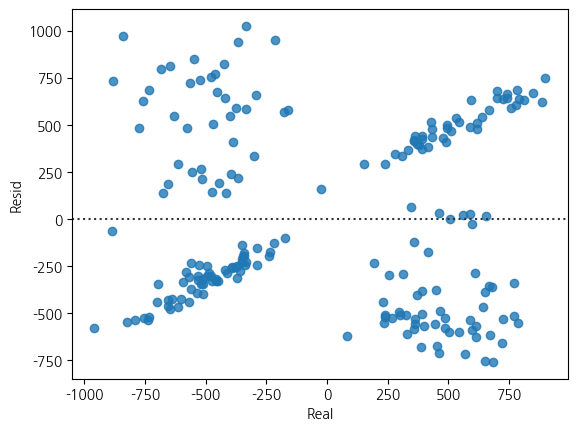

In [21]:
pred2 = predictor2.predict(test.drop(columns=label))

sns.residplot(x=test[label], y=pred2)
plt.xlabel('Real')
plt.ylabel('Resid')
plt.show()

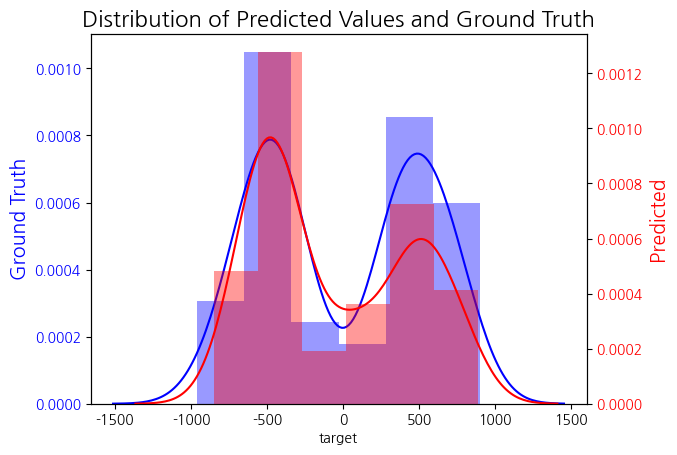

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(pred2, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

In [35]:
display(predictor2.evaluate(test.drop(columns=label), test[label], alpha_prob=0))
display(predictor2.evaluate(test.drop(columns=label), test[label], alpha_prob=0.2))

,0
root_mean_squared_error,682.310199
mean_absolute_error,474.479834
r2,-0.651459
pearsonr,0.178804


,0
root_mean_squared_error,646.419853
mean_absolute_error,472.313506
r2,-0.482291
pearsonr,0.184734


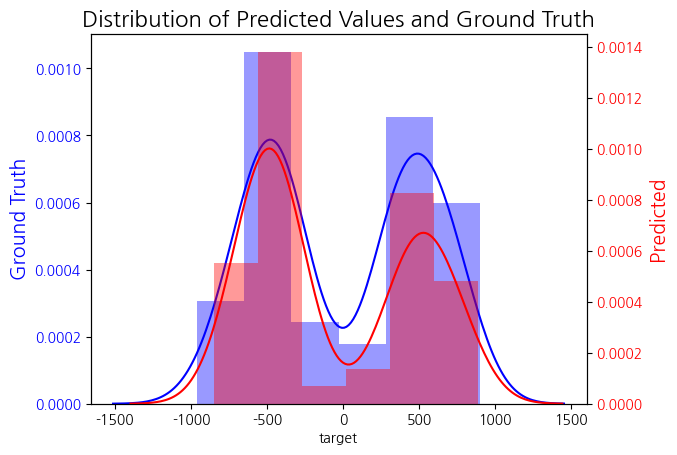

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(predictor2.predict(test.drop(columns=label), alpha_prob=0), ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

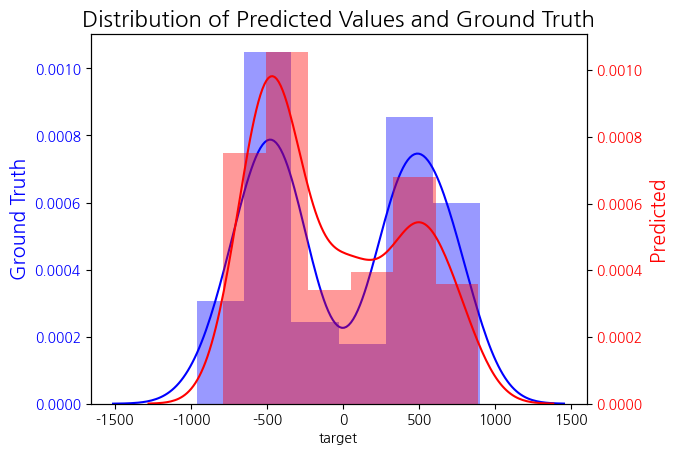

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1)

color = 'blue'
ax.set_ylabel('Ground Truth', color=color, fontsize=14)
sns.distplot(test[label], ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
sns.distplot(predictor2.predict(test.drop(columns=label), alpha_prob=0.2), ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)
plt.show()

# 참고

In [41]:
df_1['target'] = 0
df_2['target'] = 1

df = pd.concat([df_1, df_2], axis=0)

train, test = train_test_split(df, test_size=0.1, random_state=0)

clf = XGBClassifier().fit(train.drop(columns='target'), train['target'])

In [42]:
evaluate(test['target'], clf.predict(test.drop(columns='target')))

Accuracy     0.520000
Precision    0.526316
Recall       0.495050
F1           0.510204
dtype: float64